In [1]:
import sys,os,copy,glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from walker.hiscore import Hiscore
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
from smodels.tools.physicsUnits import fb
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from names import particleLabels
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))

In [2]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict


In [3]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

In [4]:
#Get highest score from each run:
protomodelsDict = {}
for ff in glob.glob('../data/signal*.dict'):
    with open(ff,'r') as f:
        pList = eval(f.read())
    run = eval(os.path.basename(ff).replace('signal','').replace('.dict',''))
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    protomodelsDict[run] = p  
    
protomodelsDictReal = {}
for ff in glob.glob('../data/real*.dict'):
    with open(ff,'r') as f:
        pList = eval(f.read())
    run = eval(os.path.basename(ff).replace('real','').replace('.dict',''))
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    protomodelsDictReal[run] = p    

In [5]:
for run in sorted(protomodelsDict.keys()):
    print(run,protomodelsDict[run])
    
Kavg = np.array([p.K for p in protomodelsDict.values()]).mean()
Kstd = np.array([p.K for p in protomodelsDict.values()]).std()
print('K (avg) = %1.2f +- %1.2f' %(Kavg,Kstd))

1 ProtoModel (XZ1,Xb,Xt): K = 10.00, Z = 3.75
2 ProtoModel (XZ1,XW,Xt): K = 2.57, Z = 2.58
3 ProtoModel (XZ1,Xb,Xt): K = 10.35, Z = 3.79
4 ProtoModel (XZ1,Xd,Xt): K = 9.66, Z = 3.67
5 ProtoModel (XZ1,Xd,Xt): K = 12.43, Z = 4.02
6 ProtoModel (XZ1,Xt,Xd): K = 10.46, Z = 3.78
7 ProtoModel (XZ1,Xg): K = 8.04, Z = 3.29
8 ProtoModel (XZ1,Xg): K = 6.83, Z = 3.25
9 ProtoModel (XZ1,Xd,Xt): K = 9.17, Z = 3.57
10 ProtoModel (XZ1,Xd,Xt): K = 10.98, Z = 3.81
11 ProtoModel (XZ1,Xd,Xt): K = 16.05, Z = 4.50
12 ProtoModel (XZ1,Xd,Xt): K = 14.19, Z = 4.21
13 ProtoModel (XZ1,Xt,Xd,Xg): K = 19.19, Z = 4.99
14 ProtoModel (XZ1,Xd,Xt): K = 9.93, Z = 3.68
15 ProtoModel (XZ1,Xt,Xd): K = 11.68, Z = 3.94
16 ProtoModel (XZ1,Xd,Xt): K = 10.44, Z = 3.77
17 ProtoModel (XZ1,Xt,Xt2): K = 5.79, Z = 3.13
18 ProtoModel (XZ1,Xg,Xt): K = 12.78, Z = 4.10
19 ProtoModel (XZ1,Xt,Xc): K = 12.63, Z = 4.02
20 ProtoModel (XZ1,Xd,Xt): K = 10.55, Z = 3.75
K (avg) = 10.69 +- 3.48


In [6]:
protomodel = protomodelsDict[4]
for pids, ssm in protomodel.ssmultipliers.items():
    if not ssm: continue
    print(pids,ssm)
print(protomodel.masses)    

(1000022, 1000022) 7.862
(1000001, 1000001) 3.508
(-1000001, 1000001) 3.508
(-1000001, -1000001) 3.508
(1000001, 1000022) 3.731
(-1000001, 1000022) 3.731
(1000006, 1000006) 0.976
(-1000006, 1000006) 0.976
(-1000006, -1000006) 0.976
(1000006, 1000022) 0.976
(-1000006, 1000022) 0.976
(1000001, 1000006) 0.976
(-1000006, 1000001) 0.976
(-1000001, 1000006) 0.976
(-1000006, -1000001) 0.976
{1000022: 531.14, 1000001: 1012.299, 1000006: 865.082}


In [7]:
run = 4
p = protomodelsDict[run]
m = Manipulator(p)
#Get predictions:
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
res = pred.predict(p)
#Get contributions
hi = Hiscore(walkerid=0,save_hiscores=False,predictor=pred)   
hi.computeParticleContributions(m)
hi.computeAnalysisContributions(m)    

[combine:0] selected predictions down via SRs from 240 to 16.
[combine:0] sorting out subsets, reduced 1036 -> 128 combinations.


combination #128/128 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:11


[combine:0] selected predictions down via SRs from 240 to 16.
[combine:0] sorting out subsets, reduced 1036 -> 128 combinations.


combination #128/128 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:12


[hiscore:0] computing contribution of Xd (1012.3): [1/2]


[combine:0] selected predictions down via SRs from 144 to 12.
[combine:0] sorting out subsets, reduced 95 -> 16 combinations.


combination #16/16 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[hiscore:0] when removing Xd, K changed: 4.186 -> 2.336 (-44.2%), Z: 2.826 -> 2.142 (100000 evts)
[hiscore:0] computing contribution of Xt (865.1): [2/2]


[combine:0] selected predictions down via SRs from 190 to 9.
[combine:0] sorting out subsets, reduced 80 -> 16 combinations.


combination #16/16 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[hiscore:0] when removing Xt, K changed: 4.186 -> 1.958 (-53.2%), Z: 2.826 -> 2.181 (100000 evts)
[hiscore:0] stored 2 particle contributions
[hiscore:0] Now computing analysis contributions
[hiscore:0] Recompute the score. Old one at K=4.19, Z=2.83
[hiscore:0] finished computing contributions
[hiscore:0] contributionsK of 0 reads 6.065846248136315
[hiscore:0] contributionsK of 1 reads 1.4679999207653625
[hiscore:0] contributionsK of 2 reads 4.074707568912846
[hiscore:0] contributionsK of 3 reads 5.652031311364783
[hiscore:0] contributionsK of 4 reads 3.4704629140206045
[hiscore:0] stored 5 analyses contributions


In [8]:
run = 4
p = protomodelsDict[run]
print('\n run %i: K = %1.2f, Z = %1.2f, muhat = %1.2f, mumax = %1.2f' %(run,p.K,p.Z,p.muhat,p.mumax))
print('\t Best Combo:')
for tp in sorted(p.bestCombo, key = lambda tp: tp.expResult.globalInfo.id):
    if tp.dataset.dataInfo.dataType == 'efficiencyMap':
        print('\t\t',tp.expResult.globalInfo.id,tp.txnames,tp.dataset.dataInfo.dataId,
          tp.dataset.dataInfo.observedN,tp.dataset.dataInfo.expectedBG,tp.dataset.dataInfo.bgError)
        print('\t\t  prediction = %1.2f' %(tp.xsection.value*tp.expResult.globalInfo.lumi))
    else:
        print('\t\t',tp.expResult.globalInfo.id,tp.txnames,tp.getUpperLimit(),tp.getUpperLimit(expected=True))
        print('\t\t  prediction = ',tp.xsection.value.asNumber(fb)*fb)
print('\t Constraints:')
for tp in sorted(p.tpList, key = lambda x: x[0], reverse=True):
    if tp[0] < 0.5: continue
    print('\t\t r = %1.2f\n' %tp[0],tp[2].expResult.globalInfo.id,tp[2].dataset.dataInfo.dataType,tp[2].txnames,
          'theory xsec =  %1.2f, UL = %s, UL_exp = %s\n' 
          %(tp[2].xsection.value.asNumber(fb),tp[2].getUpperLimit(),tp[2].getUpperLimit(expected=True)))
print('\t Particle Contributions:')
for pid,cont in p.particleContributions.items():
    print('\t\t',pid,cont)

print('\t Analysis Contributions:')
for ana,cont in p.analysisContributions.items():
    print('\t\t',ana,cont)



 run 4: K = 4.19, Z = 2.83, muhat = 0.91, mumax = 0.93
	 Best Combo:
		 ATLAS-SUSY-2013-02 [T2] SR6jtp 6 4.9 1.6
		  prediction = 0.15
		 ATLAS-SUSY-2016-07 [T2] 2j_Meff_1200 611.0 526.0 31.0
		  prediction = 51.75
		 ATLAS-SUSY-2016-16 [T2tt] tN_med 50 36.3 6.6
		  prediction = 9.61
		 CMS-SUS-12-028 [T2] 2.98E+01 [fb] 2.02E+01 [fb]
		  prediction =  1.40E+00 [fb]
		 CMS-SUS-16-050 [T2tt] 5.63E+01 [fb] 3.34E+01 [fb]
		  prediction =  1.65E+01 [fb]
	 Constraints:
		 r = 1.43
 CMS-SUS-19-006 upperLimit [T2] theory xsec =  20.38, UL = 1.42E+01 [fb], UL_exp = 1.60E+01 [fb]

		 r = 1.25
 CMS-SUS-16-033 upperLimit [T2] theory xsec =  20.38, UL = 1.63E+01 [fb], UL_exp = 2.17E+01 [fb]

		 r = 1.10
 CMS-SUS-19-006 upperLimit [T2tt] theory xsec =  16.54, UL = 1.50E+01 [fb], UL_exp = 2.56E+01 [fb]

		 r = 1.03
 CMS-SUS-16-036 upperLimit [T2] theory xsec =  20.38, UL = 1.97E+01 [fb], UL_exp = 2.27E+01 [fb]

		 r = 0.71
 CMS-SUS-16-036 upperLimit [T2tt] theory xsec =  16.54, UL = 2.32E+01 [fb], U

In [9]:
print(protomodel.possibledecays[1000006])

[(1000005, 24), (1000022, 6), (1000023, 6), (1000024, 5), (1000037, 5), (1000021, 6)]


In [10]:
#Get all particles which appears in all models:
particles = []
modelList = list(protomodelsDict.items())
modelList = sorted(modelList, key = lambda pt: pt[0])
modelList = [[-0.75,protomodelsDictReal[4]]] + modelList[:] #Add winning protomodel as run 0
modelList = np.array(modelList)
runs = modelList[:11,0]
modelList = modelList[:11,1]
for p in modelList:
    particles += p.unFrozenParticles()
particles = list(set(particles))

#Build useful dataset:
nparticles = np.array([len(p.unFrozenParticles()) for p in modelList])
Kvalues = np.array([p.K if (p.K and p.K > 0) else 0.0 for p in modelList])
Zvalues = np.array([p.Z if (p.Z and p.Z > 0) else 0.0 for p in modelList])
masses = dict([[pid,[]] for pid in particles])
for p in modelList:
    for pid in masses:
        if pid in p.masses:
            masses[pid].append(p.masses[pid])
        else:
            masses[pid].append(-100.0)
for pid in masses:
    masses[pid] = np.array(masses[pid])
dataDict = {'run' : runs, 'K' : Kvalues,
                   'nparticles' : nparticles}
dataDict.update(masses) 
df = pd.DataFrame(dataDict)

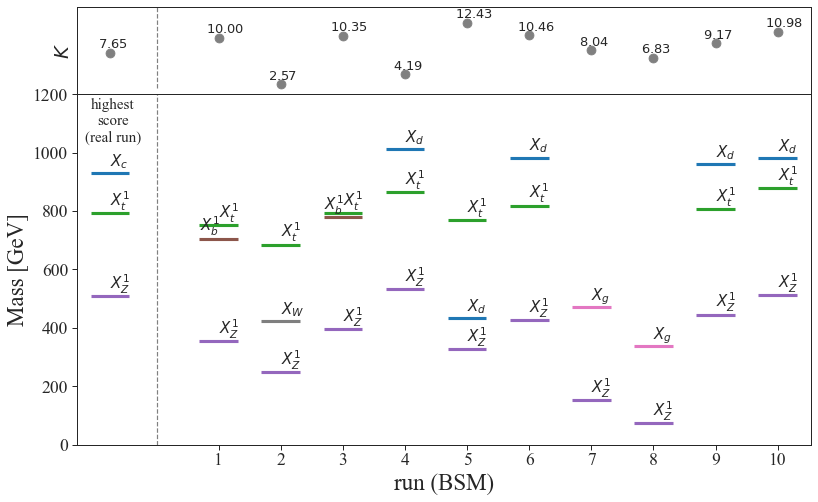

In [34]:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[1, 4]},figsize=(12,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0)

nsteps = 10

pids = [1000001, 1000004, 1000006, 1000013, 1000022] #Use same color scheme as real runs

for p in masses.keys():
    if not p in pids:
        pids.append(p)
colors = sns.color_palette('Paired',n_colors=20)[1::2]
colors = sns.color_palette('tab10',n_colors=20)
# colors = sns.color_palette('colorblind',n_colors=10)
colorsDict = dict([[pid,colors[i]] for i,pid in enumerate(pids)])
colorsDict[1000004] = colorsDict[1000001]

axarr[0].scatter(df['run'],df['K'],s=80,c='gray')
axarr[0].set_ylabel(r'$K$')
axarr[0].set_ylim(1.0,15.0)
axarr[0].set_yticks([])
for i,row in df.iterrows():
    axarr[0].annotate(r'$%1.2f$' %row['K'],(row['run']-0.2,row['K']+0.8),fontsize=13)

axarr[0].vlines(x=0,ymin=2,ymax=15,linestyle='--',color='gray')

for pid in pids:
    if not pid in masses: #Skip particles present in real run, but not the fakes
        continue
    data = df
    sns.scatterplot(x=data['run'],y=data[pid], size=1000,sizes=(1500,1500),marker='_',
                    label=r'$%s$' %(particleLabels[pid]), legend=False,
                    color=colorsDict[pid],ax=axarr[1])
    for i,m in enumerate(masses[pid]):
        if m < 0: continue
        if 'b' in particleLabels[pid]:
            axarr[1].annotate(r'$%s$' %(particleLabels[pid]),(runs[i]-0.3,m+25.),fontsize=15)
        else:
            axarr[1].annotate(r'$%s$' %(particleLabels[pid]),(runs[i],m+25.),fontsize=15)
axarr[1].set_ylim(0.,1500.0)
axarr[1].set_xlabel('run (BSM)', fontsize=23)
axarr[1].set_ylabel('Mass [GeV]', fontsize=23)
axarr[1].set_xticks(np.arange(1,df['run'].max()+1))
axarr[1].vlines(x=0,ymin=0,ymax=1200,linestyle='--',color='gray')
#     plt.plot(df['run'],m,'-',linewidth=2)

axarr[1].text(-0.7,1040,'highest\nscore\n(real run)',fontsize=15,horizontalalignment='center')
plt.ylim(0.,1200.0)



# plt.grid(axis='x') 
# plt.legend(loc=(0.8,0.85),framealpha=1.0,ncol=3,labelspacing=0.1,
#            handlelength=0.4,handletextpad=0.35,markerscale=0.8,columnspacing=1.0)
# plt.tight_layout()
plt.savefig('highScoreSignal_massesv1.pdf')
plt.show()